# Chest X-Ray Classification

Dataset Sampled from COVID-19 CHEST X-RAY DATABASE

https://www.kaggle.com/datasets/tawsifurrahman/covid19-radiography-database

-M.E.H. Chowdhury, T. Rahman, A. Khandakar, R. Mazhar, M.A. Kadir, Z.B. Mahbub, K.R. Islam, M.S. Khan, A. Iqbal, N. Al-Emadi, M.B.I. Reaz, M. T. Islam, “Can AI help in screening Viral and COVID-19 pneumonia?” IEEE Access, Vol. 8, 2020, pp. 132665 - 132676.
-Rahman, T., Khandakar, A., Qiblawey, Y., Tahir, A., Kiranyaz, S., Kashem, S.B.A., Islam, M.T., Maadeed, S.A., Zughaier, S.M., Khan, M.S. and Chowdhury, M.E., 2020. Exploring the Effect of Image Enhancement Techniques on COVID-19 Detection using Chest X-ray Images. arXiv preprint arXiv:2012.02238.


In [92]:
pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [2]:
!apt-get install libgl1 -y

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libgl1 is already the newest version (1.4.0-1).
0 upgraded, 0 newly installed, 0 to remove and 19 not upgraded.


In [79]:
import os
import tensorflow as tf
from tensorflow.python.client import device_lib

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
device_lib.list_local_devices()

Num GPUs Available:  1


2023-12-16 03:02:28.771114: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:43:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-16 03:02:28.771228: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:43:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-16 03:02:28.771272: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:43:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-16 03:02:28.771584: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:43:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-16 03:02:28.771603: I tensorflow/core/common_runtime/gpu/gpu

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 10435083137413734372
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 11257511936
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 14280966281196554371
 physical_device_desc: "device: 0, name: NVIDIA TITAN X (Pascal), pci bus id: 0000:43:00.0, compute capability: 6.1"
 xla_global_id: 416903419]

In [80]:
os.environ['TF_CPP_MIN_LOG_LEVEL']='3'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [81]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from jupyterthemes import jtplot
jtplot.style(theme = 'monokai', context = 'notebook', ticks = True, grid = False) 
# setting the style of the notebook to be monokai theme  
# this line of code is important to ensure that we are able to see the x and y axes clearly
# If you don't run this code line, you will notice that the xlabel and ylabel on any plot is black on black and it will be hard to see them. 

In [90]:
# Specify training data directory
XRay_Directory = 'Chest_X_Ray-2/Train'

In [91]:
# List the folders in the directory
os.listdir(XRay_Directory)

['0', '3', '1', '2']

In [8]:
# Use image generator to generate tensor images data and normalize them
# Use 20% of the data for cross-validation  
image_generator = ImageDataGenerator(rescale = 1./255, validation_split = 0.2)

In [9]:
# Generate batches of 40 images
# Total number of images is 133*4 = 532 images
# Training is 428 (80%) and validation is 104 (20%)
# Perform shuffling and image resizing

train_generator = image_generator.flow_from_directory(batch_size = 40,
                                                     directory = XRay_Directory,
                                                     shuffle =  True,
                                                     target_size = (256, 256),
                                                     class_mode = 'categorical',
                                                     subset = 'training')

Found 3200 images belonging to 4 classes.


In [10]:
validation_generator = image_generator.flow_from_directory(batch_size = 40,
                                                           directory = XRay_Directory, 
                                                           shuffle = True, 
                                                           target_size = (256,256), 
                                                           class_mode = 'categorical', 
                                                           subset = "validation")


Found 800 images belonging to 4 classes.


In [11]:
# Generate a batch of 40 images and labels
train_images, train_labels = next(train_generator)

In [12]:
train_labels

array([[0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.]],

In [13]:
# labels Translator 
label_names = {0 : 'Covid-19', 1 : 'Normal' , 2: 'Lung opacity', 3 : 'Viral Pneumonia'}

In [14]:
train_images.shape

(40, 256, 256, 3)

In [15]:
train_labels.shape

(40, 4)

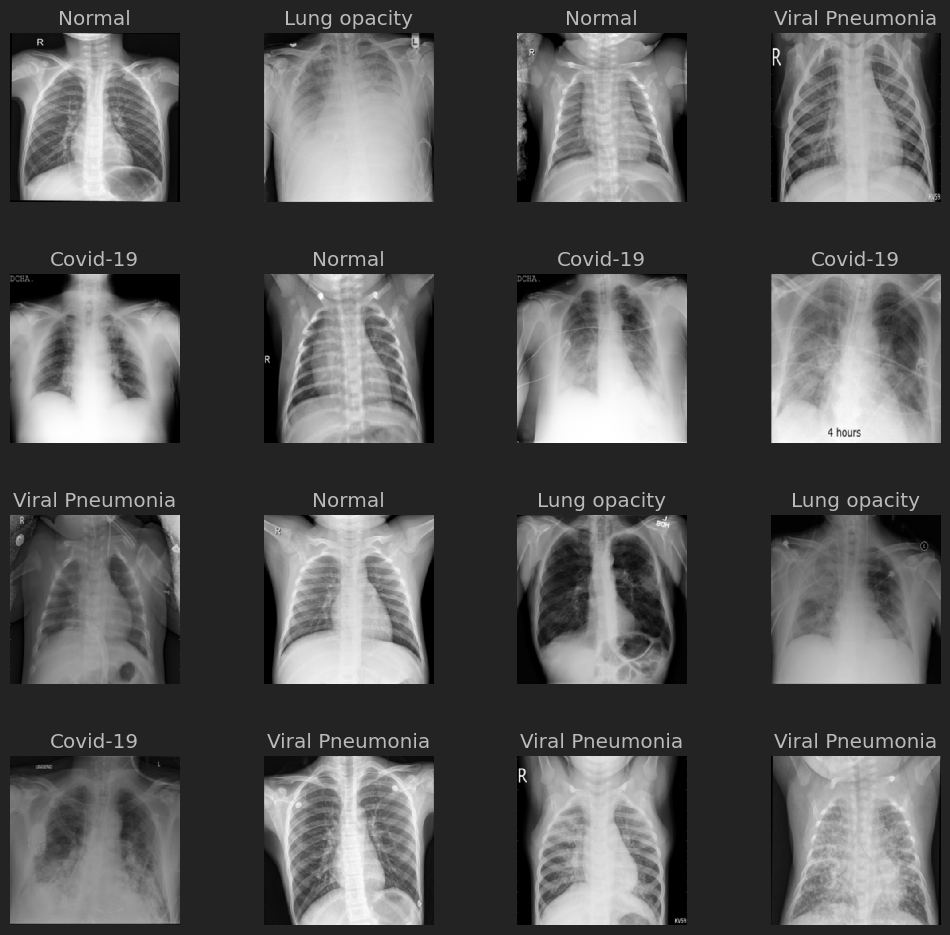

In [16]:
# Create a grid of 16 images along with their corresponding labels
L = 4
W = 4

fig, axes = plt.subplots(L, W, figsize = (12, 12))
axes = axes.ravel()

for i in np.arange(0, L*W):
    axes[i].imshow(train_images[i])
    axes[i].set_title(label_names[np.argmax(train_labels[i])])
    axes[i].axis('off')

plt.subplots_adjust(wspace = 0.5)   

## IMPORT MODEL WITH PRETRAINED WEIGHTS

In [17]:
basemodel = ResNet50(weights = 'imagenet', include_top = False, input_tensor = Input(shape = (256, 256, 3)))

2023-12-16 00:03:26.850555: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:43:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-16 00:03:26.850639: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:43:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-16 00:03:26.850669: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:43:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-16 00:03:26.850860: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:43:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-16 00:03:26.850872: I tensorflow/core/common_runtime/gpu/gpu

In [18]:
basemodel.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 262, 262, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 128, 128, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 128, 128, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                       

In [19]:
#freezing the model upto the last stage - 4 and re-training stage -5 

for layer in basemodel.layers[:-10]:
  layers.trainable = False

## TRAIN RESNET MODEL WITH THE NEW DATASETS

In [20]:
headmodel = basemodel.output
headmodel = AveragePooling2D(pool_size = (4,4))(headmodel)
headmodel = Flatten(name = 'flatten')(headmodel)
headmodel = Dense(256, activation = 'relu')(headmodel)
headmodel = Dropout(0.3)(headmodel)
headmodel = Dense(128, activation = 'relu')(headmodel)
headmodel = Dropout(0.2)(headmodel)

headmodel = Dense(4, activation = 'softmax')(headmodel)

model = Model(inputs = basemodel.input, outputs = headmodel)

In [21]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 262, 262, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 128, 128, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 128, 128, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                          

In [22]:
model.compile(loss = 'categorical_crossentropy', optimizer = optimizers.RMSprop(learning_rate = 1e-4), metrics= ["accuracy"])

In [23]:
# using early stopping to exit training if validation loss is not decreasing even after certain epochs (patience)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15)

# save the best model with lower validation loss
checkpointer = ModelCheckpoint(filepath="weights.hdf5", verbose=1, save_best_only=True)

In [24]:
train_generator = image_generator.flow_from_directory(batch_size = 4, directory= XRay_Directory, shuffle= True, target_size=(256,256), class_mode= 'categorical', subset="training")
val_generator = image_generator.flow_from_directory(batch_size = 4, directory= XRay_Directory, shuffle= True, target_size=(256,256), class_mode= 'categorical', subset="validation")

Found 3200 images belonging to 4 classes.
Found 800 images belonging to 4 classes.


In [25]:
with tf.device("/device:GPU:0"):
    history = model.fit(train_generator, steps_per_epoch= train_generator.n // 4, epochs = 50, validation_data= val_generator, validation_steps= val_generator.n // 4, callbacks=[checkpointer, earlystopping])

Epoch 1/50


2023-12-16 00:03:42.670999: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8906
2023-12-16 00:03:44.498733: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f5300adce30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-16 00:03:44.498784: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA TITAN X (Pascal), Compute Capability 6.1
2023-12-16 00:03:44.504651: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1702685024.550067   30919 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


800/800 [==============================] - ETA: 0s - loss: 0.5499 - accuracy: 0.8400
Epoch 1: val_loss improved from inf to 4.39802, saving model to weights.hdf5


/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


800/800 [==============================] - 88s 81ms/step - loss: 0.5499 - accuracy: 0.8400 - val_loss: 4.3980 - val_accuracy: 0.5288
Epoch 2/50
800/800 [==============================] - ETA: 0s - loss: 0.3030 - accuracy: 0.9187
Epoch 2: val_loss improved from 4.39802 to 0.40664, saving model to weights.hdf5
800/800 [==============================] - 64s 80ms/step - loss: 0.3030 - accuracy: 0.9187 - val_loss: 0.4066 - val_accuracy: 0.8863
Epoch 3/50
800/800 [==============================] - ETA: 0s - loss: 0.2364 - accuracy: 0.9444
Epoch 3: val_loss did not improve from 0.40664
800/800 [==============================] - 63s 78ms/step - loss: 0.2364 - accuracy: 0.9444 - val_loss: 2.9682 - val_accuracy: 0.8700
Epoch 4/50
800/800 [==============================] - ETA: 0s - loss: 0.1418 - accuracy: 0.9597
Epoch 4: val_loss did not improve from 0.40664
800/800 [==============================] - 62s 78ms/step - loss: 0.1418 - accuracy: 0.9597 - val_loss: 8.4553 - val_accuracy: 0.8413
Epoch

In [83]:
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


## EVALUATE TRAINED DEEP LEARNING MODE

In [84]:
# load json and create model

from tensorflow.keras.models import model_from_json

json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
# load weights into new model
model.load_weights("model.h5")
print("Loaded model from disk")


Loaded model from disk


In [85]:
# Let's compile the model 
model.compile(optimizer = tf.keras.optimizers.RMSprop(0.0001), loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [88]:
test_directory = 'Chest_X_Ray-2/Test'

In [89]:
test_gen = ImageDataGenerator(rescale = 1./255)

test_generator = test_gen.flow_from_directory(batch_size = 4, directory= test_directory, shuffle= True, target_size=(256,256), class_mode= 'categorical')

evaluate = model.evaluate_generator(test_generator, steps = test_generator.n // 4, verbose =1)

print('Accuracy Test : {}'.format(evaluate[1]))

Found 256 images belonging to 4 classes.


/tmp/ipykernel_6494/4105974032.py:5: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  evaluate = model.evaluate_generator(test_generator, steps = test_generator.n // 4, verbose =1)


64/64 [==============================] - 4s 31ms/step - loss: 0.2743 - accuracy: 0.9570
Accuracy Test : 0.95703125


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import cv2
prediction = []
original = []
image = []

for i in range(len(os.listdir(test_directory))):
  for item in os.listdir(os.path.join(test_directory,str(i))):
    img= cv2.imread(os.path.join(test_directory,str(i),item))
    img = cv2.resize(img,(256,256))
    image.append(img)
    img = img / 255
    img = img.reshape(-1,256,256,3)
    predict = model.predict(img)
    predict = np.argmax(predict)
    prediction.append(predict)
    original.append(i)

1/1 [==============================] - 0s 31ms/step


In [ ]:
len(original)

256

In [ ]:
score = accuracy_score(original,prediction)
print("Test Accuracy : {}".format(score))

Test Accuracy : 0.95703125


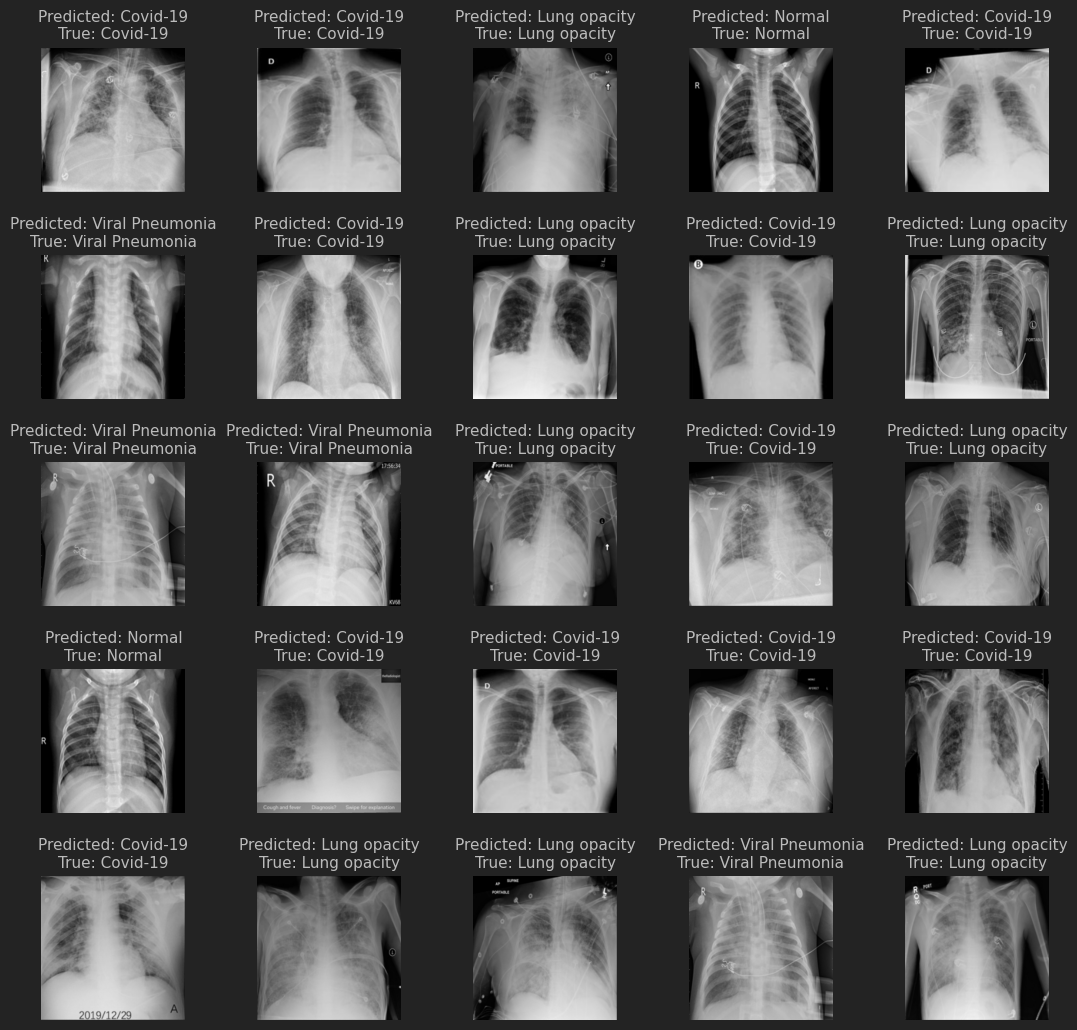

In [129]:
import random  

random.seed(42)

L = 5
W = 5

fig, axes = plt.subplots(L, W, figsize = (13, 13))
axes = axes.ravel()

for i, j in enumerate(random.sample(range(len(original)), k=L*W)):
    axes[i].imshow(image[j])
    axes[i].set_title('Predicted: {}\nTrue: {}'.format(str(label_names[prediction[j]]), str(label_names[original[j]])), fontsize = 11)
    axes[i].axis('off')

plt.subplots_adjust(wspace = 0.5) 

plt.savefig("output.png")


In [97]:
print(classification_report(np.asarray(original), np.asarray(prediction)))

              precision    recall  f1-score   support

           0       0.97      0.98      0.98        64
           1       0.94      1.00      0.97        64
           2       0.93      0.97      0.95        64
           3       1.00      0.88      0.93        64

    accuracy                           0.96       256
   macro avg       0.96      0.96      0.96       256
weighted avg       0.96      0.96      0.96       256



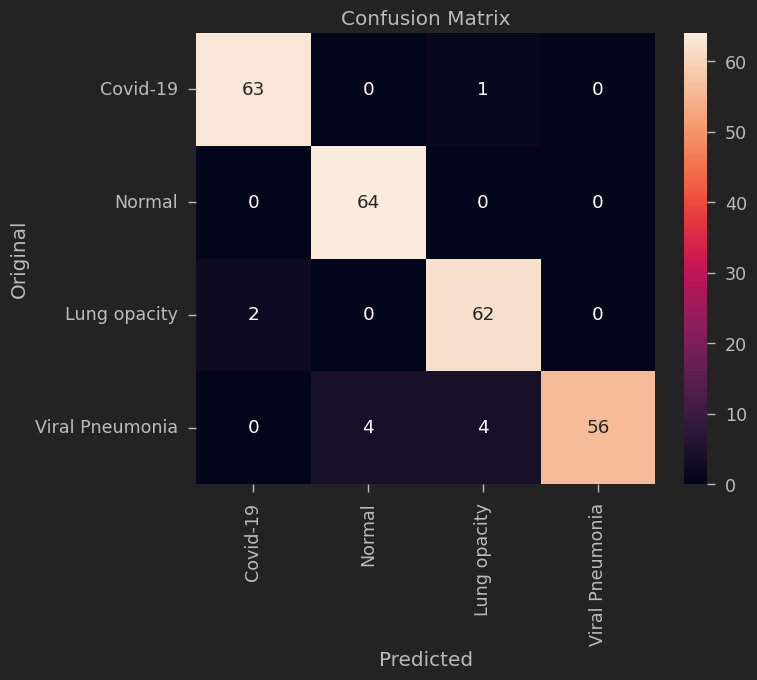

In [122]:
classes = ['Covid-19', 'Normal', 'Lung opacity', 'Viral Pneumonia']

cm = confusion_matrix(np.asarray(original), np.asarray(prediction))
ax = sns.heatmap(cm, annot = True, xticklabels=classes, yticklabels=classes)
plt.yticks(rotation=0) 

ax.set_xlabel('Predicted')
ax.set_ylabel('Original')
ax.set_title('Confusion Matrix')
plt.tight_layout()
plt.savefig("confusion.png")